In [1]:
import numpy as np
from scipy.integrate import dblquad
from scipy.integrate import quad
from scipy.optimize import curve_fit
from scipy.optimize import fsolve
from tqdm import tqdm
import os
import re
import matplotlib.pyplot as plt
plt.rcParams.update({
    "text.usetex": True,
    "font.family": "Computer Modern",
    "figure.dpi": 100,
})

class fixed_values:
  def __init__(self):
    self.h=4.135667e-9 #eV us
    self.hbar=self.h/(2*np.pi) #eV us rad-1
    self.c=299792458 #um/us
    self.k_B=8.617343e-5 #eV/K
    self.eta_pb_max=0.59
    self.energy_au=27.211386 #eV
    self.time_au=2.418884e-11 #us
    self.length_au=5.291772e-5 #um
consts = fixed_values()

In [25]:
class aluminum:
  def __init__(self):
    self.nue = 17.2e9 #eV-1 um-3
    self.D=15000 #um2 us-1
    self.Tc = 1.11 #K
    self.Delta = 1.768*consts.k_B*self.Tc #eV
    self.omega_D = 9.66e7 #in MHz rad
    self.T_D = consts.hbar*self.omega_D/consts.k_B #K
    self.v_L = 6420 #um/us
    self.v_T = 3040 #um/us

    rho_m = 2.7 #g cm-3
    Z = 3 #valence electrons per atom
    m_a = 26.982 #u
    N_A = 6.022e23 #u/g
    self.n = N_A * Z * rho_m / m_a * 1e-12 # electrons um-3
    self.rho_m = rho_m*5.61e32/consts.c**2 *1e-12#eV c-2 um-3

    self.rs = 1.097e-4 #um
    self.rs_au = self.rs / consts.length_au

    self.alpha2_av = 1.93e-3 #eV
    
    self.OmegaD = consts.k_B*self.T_D
    self.E1 = 67*self.OmegaD
    self.tau_0 = 0.11 #us


Al = aluminum()

def calc_RS(metal):
    p_fermi = np.sqrt((consts.hbar)**2*(3*np.pi**2*metal.n)**(2/3))
    k_fermi = p_fermi/consts.hbar
    mstar = 2*consts.hbar**2*metal.nue*np.pi**2/k_fermi # from suppl
    v_fermi = p_fermi/mstar
    epsilonF = (consts.hbar)**2/(2*mstar)*(3*np.pi**2*metal.n)**(2/3)
    tau_elastic = metal.nue*metal.D*mstar/metal.n # <= Einstein relation (sigma = e^2 N(0) D) and drude effective mass, tau elastic time
    l=v_fermi*tau_elastic
    k_T = metal.Delta/consts.hbar/metal.v_T # k_T at the energy Delta
    T=k_T*metal.v_L

    beta = (2/3 * epsilonF)**2 * metal.nue/(2*metal.N*metal.M*metal.v_L**2)
    tau_epsilon = 1/(np.pi**4*beta/5 * p_fermi*l*T**4/(p_fermi*metal.v_T)**3 * (1+3/2*(metal.v_L/metal.v_T)**5))
    return tau_epsilon

class tantalum:
  def __init__(self):
    self.nue = 30.3e9 #eV-1 um-3
    self.D = 50 #um2 us-1
    self.T_D = 221 #K
    self.Tc = 0.87 #K
    self.Delta = 1.768*consts.k_B*self.Tc #eV
    self.omega_D = consts.k_B*self.T_D/consts.hbar #in MHz rad
    self.v_L = 4.35e3 #um/us
    self.v_T = 1.74e3 #um/us

    rho_m = 17.1 #g cm-3
    Z = 2 #valence electrons per atom
    m_a = 180.94788 #u
    N_A = 6.022e23 #u/g
    self.n = N_A * Z * rho_m / m_a * 1e-12 # electrons um-3
    self.rho_m = rho_m*5.61e32 * 1e-12#eV c-2 um-3

    self.OmegaD = consts.k_B*self.T_D
    self.rs = 1.2947e-4 #um # based on n_e => spherical volume => radius
    self.rs_au = self.rs/consts.length_au

    self.N = 1.8038e9 #um-3 # https://next-gen.materialsproject.org/materials/mp-569794?formula=Ta#crystal_structure
    self.M = m_a * 9.315e8 #eV c-2

    self.alpha2_av = 1.38e-3 #eV

    self.tau_0 = calc_RS(self)
    #self.tau_0 = 0.150 #us

bTa = tantalum()

In [26]:
def calc_LP(metal,energy):
    p_fermi = np.sqrt((consts.hbar)**2*(3*np.pi**2*metal.n)**(2/3))
    k_fermi = p_fermi/consts.hbar
    mstar = 2*consts.hbar**2*metal.nue*np.pi**2/k_fermi # from suppl
    epsilonF = (consts.hbar)**2/(2*mstar)*(3*np.pi**2*metal.n)**(2/3)
    tau_ee = 1/((energy**2 / (consts.hbar*epsilonF))*metal.rs_au**0.5 / 7.96)
    return tau_ee

def calc_pippard(metal,energy):
    omega = energy/consts.hbar

    p_fermi = np.sqrt((consts.hbar)**2*(3*np.pi**2*metal.n)**(2/3))
    k_fermi = p_fermi/consts.hbar
    mstar = 2*consts.hbar**2*metal.nue*np.pi**2/k_fermi # from suppl
    v_fermi = p_fermi/mstar
    tau_elastic = metal.nue*metal.D*mstar/metal.n # <= Einstein relation (sigma = e^2 N(0) D) and drude effective mass, tau elastic time

    l=v_fermi*tau_elastic

    k_L=omega/metal.v_L
    alpha_L = metal.n*mstar/(metal.rho_m*metal.v_L*tau_elastic) * (1/3 * (k_L**2*l**2*np.arctan(k_L*l)/(k_L*l-np.arctan(k_L*l))) - 1)
    tau_ph_L = 1/(metal.v_L*alpha_L)

    k_T=omega/metal.v_T
    g = 3/(2*k_T**2*l**2)*((k_T**2*l**2+1)/(k_T*l)*np.arctan(k_T*l)-1)
    alpha_T = metal.n*mstar/(metal.rho_m*metal.v_T*tau_elastic) * (1-g)/g
    tau_ph_T = 1/(metal.v_T*alpha_T)
    return tau_ph_L,tau_ph_T

@np.vectorize
def calc_kaplan(metal,energy):
    p_fermi = np.sqrt((consts.hbar)**2*(3*np.pi**2*metal.n)**(2/3))
    k_fermi = p_fermi/consts.hbar
    mstar = 2*consts.hbar**2*metal.nue*np.pi**2/k_fermi # from suppl
    epsilonF = (consts.hbar)**2/(2*mstar)*(3*np.pi**2*metal.n)**(2/3)

    tau_s = metal.tau_0/((metal.Delta/(consts.k_B*metal.Tc))**3*(1/3*((energy/metal.Delta)**2-1)**(3/2)+5/2*((energy/metal.Delta)**2-1)**(1/2)-metal.Delta/(2*energy)*(1+4*(energy/metal.Delta)**2)*np.log(energy/metal.Delta+((energy/metal.Delta)**2-1)**(1/2))))

    f = lambda e : 1-np.heaviside(epsilonF-e,0.5)

    RB_int = lambda omega : 1/(omega**2 - metal.Delta**2)**0.5 * (omega*(energy-omega)+metal.Delta**2)/((energy-omega)**2-metal.Delta**2)**0.5 * (1-f(omega)-f(energy-omega))
    Rphs_int = lambda omega : 1/(omega**2 - metal.Delta**2)**0.5 * (omega*(energy+omega)-metal.Delta**2)/((energy+omega)**2-metal.Delta**2)**0.5 * (f(omega)-f(energy+omega))

    RB = 4*np.pi*metal.nue*metal.alpha2_av/(consts.hbar*metal.n) * quad(RB_int,metal.Delta,energy-metal.Delta)[0]
    Rphs = 8*np.pi*metal.nue*metal.alpha2_av/(consts.hbar*metal.n) * quad(Rphs_int,metal.Delta,np.inf)[0]


    return tau_s, 1/RB#, Rphs

Text(0, 0.5, 'Rate (MHz)')

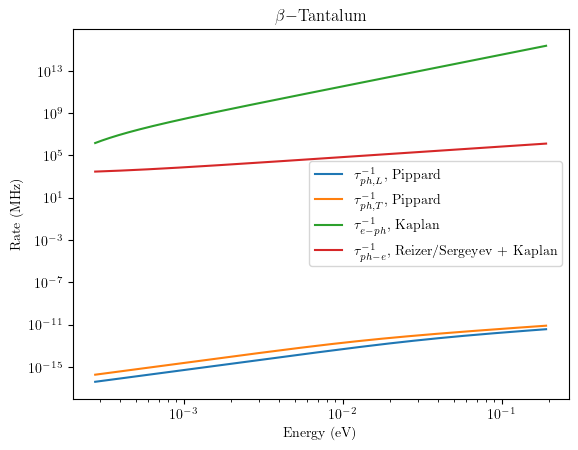

In [27]:
E_range = np.geomspace(2.1*bTa.Delta,10*bTa.OmegaD,1000)
tau_ee = calc_LP(bTa,E_range)
tau_ph_L,tau_ph_T = calc_pippard(bTa,E_range)
tau_s,tau_B = calc_kaplan(bTa,E_range)

#plt.loglog(E_range,1/tau_ee,label=r'$\frac{1}{\tau_{e-e}}$')
plt.loglog(E_range,1/tau_ph_L,label=r'$\tau_{ph,L}^{-1}$, Pippard')
plt.loglog(E_range,1/tau_ph_T,label=r'$\tau_{ph,T}^{-1}$, Pippard')
plt.loglog(E_range,1/tau_s,label=r'$\tau_{e-ph}^{-1}$, Kaplan')
plt.loglog(E_range,1/tau_B,label=r'$\tau_{ph-e}^{-1}$, Reizer/Sergeyev + Kaplan')
plt.legend()
plt.title(r'$\beta-$Tantalum')
plt.xlabel('Energy (eV)')
plt.ylabel('Rate (MHz)')

In [32]:
calc_kaplan(bTa,4.5*bTa.Delta)

(array(2.14482855e-08), array(0.00020312))

Text(0, 0.5, 'Rate (MHz)')

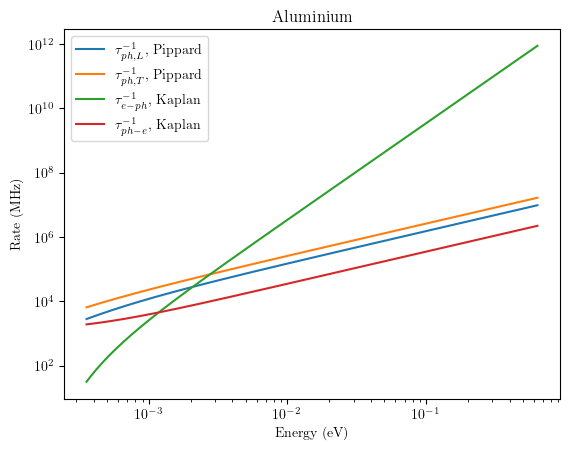

In [29]:
E_range = np.geomspace(2.1*Al.Delta,10*Al.OmegaD,1000)
tau_ee = calc_LP(Al,E_range)
tau_ph_L,tau_ph_T = calc_pippard(Al,E_range)
tau_s,tau_B = calc_kaplan(Al,E_range)

#plt.loglog(E_range,1/tau_ee,label=r'$\frac{1}{\tau_{e-e}}$')
plt.loglog(E_range,1/tau_ph_L,label=r'$\tau_{ph,L}^{-1}$, Pippard')
plt.loglog(E_range,1/tau_ph_T,label=r'$\tau_{ph,T}^{-1}$, Pippard')
plt.loglog(E_range,1/tau_s,label=r'$\tau_{e-ph}^{-1}$, Kaplan')
plt.loglog(E_range,1/tau_B,label=r'$\tau_{ph-e}^{-1}$, Kaplan')
plt.legend()
plt.title('Aluminium')
plt.xlabel('Energy (eV)')
plt.ylabel('Rate (MHz)')

In [6]:
length = 90
width = 10
height = 0.04

def distfunc(phi,theta):
    return np.min(np.stack([height/2/np.sqrt(1-np.sin(phi)**2),length/2/np.sqrt(1-np.sin(theta)**2),width/2/np.sqrt(1-np.sin(np.pi/2-theta)**2)],axis=-1),axis=-1)

mfp = dblquad(distfunc,0,np.pi/2,0,np.pi/2)[0]*4/np.pi**2

D_ph = mfp*bTa.v_L/3

print(D_ph, '= D (um2/us)')
mfp

144.6886221229798 = D (um2/us)


0.09978525663653781